# Analyse the relationship between Bouguer and topography

In [1]:
%matplotlib inline
from __future__ import division, print_function
import datetime
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
datapath = 'data/{}'
datafile = 'processed-tim_r5-africa-1deg.txt'
outfile = 'residual-regional-tim_r5-africa-1deg.txt'

## Load processed data

Data processed by [data_processing.ipynb](data_processing.ipynb)

In [3]:
with open(datapath.format(datafile)) as f:
    # Read the projection and the shape from the header
    for i in range(5):
        line = f.readline()
    line = f.readline()
    parts = line.split(':')
    projection = parts[1].strip()
    line = f.readline()
    parts = line.split(':')
    shape = eval(parts[1].strip())
    # Load the numeric data
    lat, lon, x, y, height, topo, bouguer = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 3, 4, 7, 10])
    x = x.reshape(shape)
    y = y.reshape(shape)

In [4]:
s, n, w, e = lat.min(), lat.max(), lon.min(), lon.max()

In [5]:
bm = Basemap(projection=projection, llcrnrlat=s, llcrnrlon=w, urcrnrlat=n, urcrnrlon=e, lat_ts=(n + s)/2)

In [6]:
def plot_map(data, cmap, cmlabel):
    plt.figure(figsize=(8, 7))
    bm.contourf(y, x, data.reshape(shape), 50, cmap=cmap)
    cb = plt.colorbar()
    cb.set_label(cmlabel)
    bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
    bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
    bm.drawcoastlines(color='grey')

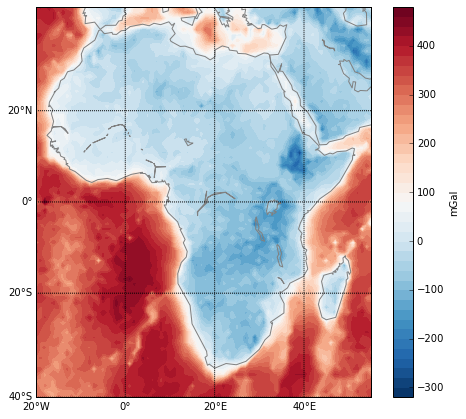

In [7]:
plot_map(bouguer, 'RdBu_r', 'mGal')

## Bouguer vs topography

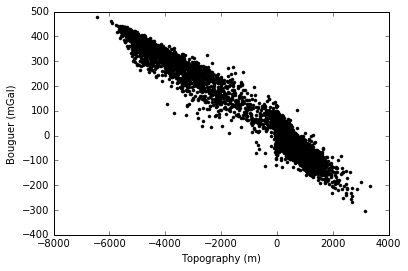

In [8]:
plt.figure()
plt.plot(topo, bouguer, '.k')
plt.xlabel('Topography (m)')
plt.ylabel('Bouguer (mGal)')

Create the equivalent topography using the densities defined below.

In [9]:
rhoa = 1040
rhoc = 2670
topo_eq = np.copy(topo)
topo_eq[topo < 0] = topo[topo < 0]*(rhoc - rhoa)/rhoc

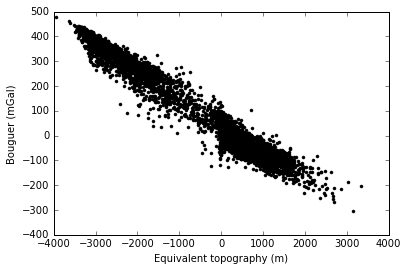

In [10]:
plt.figure()
plt.plot(topo_eq, bouguer, '.k')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

Fit a line to the equivalent topography and Bouguer.

In [17]:
def robust_regression(x, y):
    weight = None
    for i in range(10):
        a, b = sp.polyfit(x, y, w=weight, deg=1)
        residuals = y - (a*x + b)
        residuals[np.abs(residuals) < 1e-10] = 1e-10
        weight = 1/np.abs(residuals)
    return a, b, a*x + b        

In [18]:
a, b, line = robust_regression(topo_eq, bouguer)
print('bouguer = {}*t_eq + {}'.format(a, b))

bouguer = -0.114511006635*t_eq + 31.8201057515


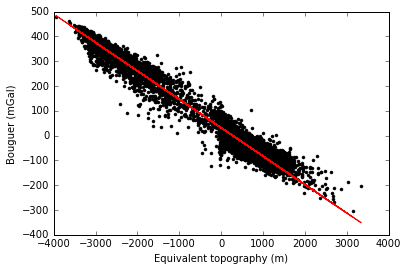

In [19]:
plt.figure()
plt.plot(topo_eq, bouguer, '.k')
plt.plot(topo_eq, line, '-r')
plt.xlabel('Equivalent topography (m)')
plt.ylabel('Bouguer (mGal)')

In [20]:
isostatic_moho_grav = line
crustal_grav = bouguer - isostatic_moho_grav

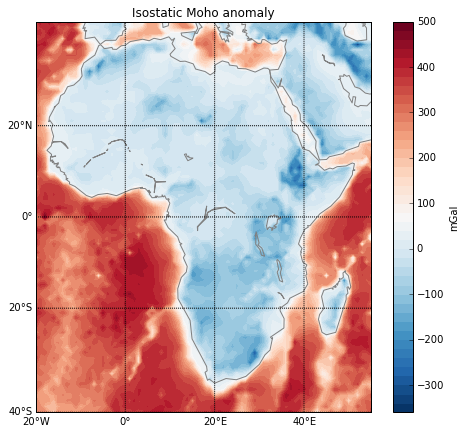

In [21]:
plot_map(isostatic_moho_grav, 'RdBu_r', 'mGal')
plt.title('Isostatic Moho anomaly')

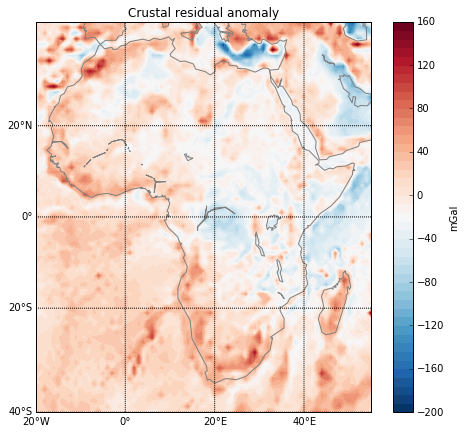

In [22]:
plot_map(crustal_grav, 'RdBu_r', 'mGal')
plt.title('Crustal residual anomaly')

## Save the output

In [23]:
date = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Generated by {notebook}.ipynb
# Date: {date}
# Processed gravity data: {datafile}
# Projection: {proj}
# Grid shape: {shape}
# Columns: lat  lon  x  y  height  topo  isostatic_moho_anomaly  crustal_residual_anomaly
""".format(notebook='isostatic_analysis',
           date=date, 
           datafile=datafile,
           proj=bm.projection,
           shape=shape)
with open(datapath.format(outfile), 'w') as f:
    f.write(header)
    datamatrix = np.array([lat, lon, x.ravel(), y.ravel(), height, topo, isostatic_moho_grav, crustal_grav]).T
    np.savetxt(f, datamatrix, fmt='%.4f')